# Fingerübung
### Ex. 2.2
###### load the zip file and open only .xml data without duplicates

In [1]:
import zipfile
import en_core_web_sm
import xmltodict
import numpy as np
from bs4 import BeautifulSoup
import spacy #should be additionally installed, see 'requirements.txt'
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
zf = zipfile.ZipFile('training.zip')

#uncomment if you want check which files are in
'''
for x in zf.namelist():
    print(x)
'''


nlp = en_core_web_sm.load()

In [3]:
#uncomment if you want to 'print' one of the .xml files to see its content

'''
file=zf.open('__MACOSX/Traning/ANC/WhereToJapan/._Asakusa.xml')
bs = BeautifulSoup(file, 'xml')
print(bs.prettify())
file.close()


'''

def dict_update(di, el, n):
    '''
    this is just for convinence to update the dictionaries
    
    '''
    if el[0] not in di:
        di.update({el[0]: n})
    else:
        di[el[0]]+=n
    return di


In [4]:
'''
file=zf.open('Traning/CP/47_N_22_E.xml')
bs = BeautifulSoup(file, 'xml')
print(bs.prettify())
file.close()
'''
#the whole texts will be here:
data=''

#the number of entities:
number = dict()

#the number of different QsLink:
qs_number = dict()

#the prepositions in different files has differnet ids, therefore we just list the preposition for each QsLink and OLink
list1=set()
list2=set()

#the motion verben
motion=dict()

### Ex 2.3

##### determine how many different tags  are there

In [5]:
for name in zf.namelist():
    #we want only .xml files
    if not name.endswith('.xml'): continue
        
    #we should not count twice (in '_MACOSX' and in 'Traning' )
    if '__MACOSX/' in name: continue
    
    f = zf.open(name)
    xml_document = xmltodict.parse(f)
    f.close()
    text_tags = xml_document['SpaceEvalTaskv1.2']['TEXT']
    data+=text_tags 
    
    
    text_tags = xml_document['SpaceEvalTaskv1.2']['TAGS']
    
    #there are one case where QsLink Trigger is given(with id and not just ''), but there are no Spatial signals in the file. 
    #therefore need extra boolean variable, to avoid errors
    b = 'SPATIAL_SIGNAL' in [x[0] for x in text_tags.items()]
    for x in text_tags.items():
        if not isinstance(x[1], list):
            n = 1
            
            #count the number of different QsLinks:
            if x[0] == 'QSLINK':
                if x[1]['@relType'] not in qs_number:
                    qs_number.update({x[1]['@relType']: 1})
                else:
                    qs_number[x[1]['@relType']] += 1
                if b and not isinstance(text_tags['SPATIAL_SIGNAL'], list):
                    if text_tags['SPATIAL_SIGNAL']['@id'] == x[1]['@trigger']:
                        list1.add(text_tags['SPATIAL_SIGNAL']['@text'])
                if b and isinstance(text_tags['SPATIAL_SIGNAL'], list):
                    for z in text_tags['SPATIAL_SIGNAL']:
                        if z['@id'] == x[1]['@trigger']:
                            list1.add(z['@text'])
            if x[0] == 'OLINK':
                if b and not isinstance(text_tags['SPATIAL_SIGNAL'], list):
                    if text_tags['SPATIAL_SIGNAL']['@id'] == x[1]['@trigger']:
                        list2.add(text_tags['SPATIAL_SIGNAL']['@text'])
                if b and isinstance(text_tags['SPATIAL_SIGNAL'], list):
                    for z in text_tags['SPATIAL_SIGNAL']:
                        if z['@id'] == x[1]['@trigger']:
                            list2.add(z['@text'])
            if x[0] == 'MOTION':
                if x[1]['@text'] not in motion:
                    motion.update({x[1]['@text']: 1})
                else:
                    motion[x[1]['@text']] += 1
                
        else: 
            n = len(x[1])
            if x[0]=='QSLINK':
                for y in x[1]:
                    if y['@relType'] not in qs_number:
                        qs_number.update({y['@relType']: 1})
                    else:
                        qs_number[y['@relType']]+=1
                    if b and not isinstance(text_tags['SPATIAL_SIGNAL'], list):
                        if text_tags['SPATIAL_SIGNAL']['@id'] == y['@trigger']:
                            list1.add(text_tags['SPATIAL_SIGNAL']['@text'])
                    if b and isinstance(text_tags['SPATIAL_SIGNAL'], list):
                        for z in text_tags['SPATIAL_SIGNAL']:
                            if z['@id'] == y['@trigger']:
                                list1.add(z['@text'])
            if x[0] == 'OLINK':
                for y in x[1]:
                    if b and not isinstance(text_tags['SPATIAL_SIGNAL'], list):
                        if text_tags['SPATIAL_SIGNAL']['@id'] == y['@trigger']:
                            list2.add(text_tags['SPATIAL_SIGNAL']['@text'])
                    if b and isinstance(text_tags['SPATIAL_SIGNAL'], list):
                        for z in text_tags['SPATIAL_SIGNAL']:
                            if z['@id'] == y['@trigger']:
                                list2.add(z['@text'])   
            if x[0] == 'MOTION':
                for y in x[1]:
                    if y['@text'] not in motion:
                        motion.update({y['@text']: 1})
                    else:
                        motion[y['@text']] += 1
                    
        dict_update(number, x, n)
    f.close()


In [6]:
texts=nlp(data)
#tokenized text (all the texts)
text = [t.text for t in texts]
#PoS tags of the text
tokens_text = [t.pos_ for t in texts]

#tags = [t.tag_ for t in texts] 

#for simplicity:
tokens_text = np.array(tokens_text)

#set of PoS tags in the text
tokens = set(tokens_text)
print('PoS \n')
for x in tokens:
    print("{: <20} {: <30} {: <20}".format(*[x, spacy.explain(x), len(tokens_text[np.array(tokens_text==x)])]))

PoS 

ADP                  adposition                     3006                
INTJ                 interjection                   15                  
PART                 particle                       491                 
NUM                  numeral                        673                 
DET                  determiner                     3203                
X                    other                          30                  
AUX                  auxiliary                      1031                
SCONJ                subordinating conjunction      431                 
SYM                  symbol                         28                  
PRON                 pronoun                        1362                
SPACE                space                          707                 
NOUN                 noun                           5029                
PUNCT                punctuation                    3481                
VERB                 verb                    

In [7]:
print('Number of different Entities \n')
for x in number:
    print("{: <20} {: <30}".format(*[x, number[x]]))
    

Number of different Entities 

PLACE                1852                          
PATH                 434                           
SPATIAL_ENTITY       1417                          
NONMOTION_EVENT      341                           
MOTION               771                           
SPATIAL_SIGNAL       714                           
MOTION_SIGNAL        526                           
MEASURE              170                           
QSLINK               970                           
OLINK                244                           
MOVELINK             803                           
MEASURELINK          93                            
METALINK             1788                          
CP                   17                            
URL                  17                            
MLINK                42                            


In [8]:
print('Number of different QsLink types \n')

for x in qs_number:
    print("{: <20} {: <30}".format(*[x, qs_number[x]]))

Number of different QsLink types 

NTPP                 42                            
IN                   586                           
EC                   196                           
TPP                  53                            
EQ                   35                            
PO                   12                            
OUT                  3                             
DC                   41                            
                     2                             


##### We won't consider the multiple whitespaces to determine the length of a sentence

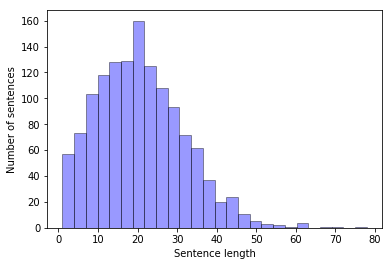

In [9]:
sentences_length=[]
for sent in texts.sents:
    sentences_length.append(len([token for token in sent if not token.is_space]))

# seaborn histogram
sns.distplot(sentences_length, bins = int(max(sentences_length)/3), hist=True, kde=False, 
             color = 'blue',  hist_kws={'edgecolor':'black'})
plt.xlabel("Sentence length")
plt.ylabel("Number of sentences")
plt.show()

In [10]:
print('QsLinks are triggered by: \n', list1)
print('\n \n')
print('OLinks are triggered by: \n', list2)

QsLinks are triggered by: 
 {'on top of', 'with', 'houses', 'through', 'apart from', 'to', 'up', 'connects', 'surrounding', 'overlooking', 'where', 'covered', 'On', 'away from', 'apart', 'has', 'including', 'under', 'afar', 'in', 'filled', 'part         of', 'Down', 'packed', 'along', 'restricted', 'into', 'beside', 'inside', 'up to', 'inhabited', 'contain', 'full of', 'covering', 'coiling up', 'further', 'atop', 'outside', 'contains', 'directly beneath', 'In', 'behind', 'of', 'In front of', 'away', 'surmounted', 'stocked', 'far from', 'Everywhere', 'on', 'on top', 'for', 'Along', 'against', 'inside of', 'around', 'bordering', 'next to', 'adjacent to', 'in front of', 'packed with', 'over', 'between', 'about', 'out of', 'line', 'at', 'house', 'upon', 'after', 'surrounded', 'At', 'from', 'across'}

 

OLinks are triggered by: 
 {'above', 'beneath', 'on top of', 'surrounding', 'up', 'to the west from', 'to', 'Southeast of', 'overlooking', 'north of', 'covered', 'On', 'south of', 'north', 

In [11]:
def getLastItem(dictionary):
    last_keyval = dictionary.popitem()
    return {last_keyval[0]:last_keyval[1]}

print('five most frequent verbs:\n ')
dic={k: v for k, v in sorted(motion.items(), key=lambda item: item[1])}
for i in range(5):
    print(getLastItem(dic))

five most frequent verbs:
 
{'biked': 22}
{'visited': 21}
{'biking': 16}
{'bike': 15}
{'go': 15}


### Ex 2.4

In [12]:
file=zf.open('Traning/ANC/WhereToMadrid/Highlights_of_the_Prado_Museum.xml')
xml1 = xmltodict.parse(file)   
file.close()

file=zf.open('Traning/RFC/Bicycles.xml')
xml2 = xmltodict.parse(file)   
file.close()



In [13]:
def gr(xml_document):
    sp_en = xml_document['SpaceEvalTaskv1.2']['TAGS']['SPATIAL_ENTITY']
    pl = xml_document['SpaceEvalTaskv1.2']['TAGS']['PLACE']
    met = xml_document['SpaceEvalTaskv1.2']['TAGS']['METALINK']


    l_sp=dict()
    l_pl=dict()
    l_m=[]

    for x in sp_en:
        l_sp.update({x['@id']:x['@text']})
    for x in pl:
        l_pl.update({x['@id']:x['@text']})
    for x in met:
        l_m.append((x['@fromID'], x['@toID']))
    
    nodes = [set(l_m[0])]

    for x in l_m:
        b = 0
        for y in nodes:
            if x[0] in y or x[1] in y:
                y.add(x[0])
                y.add(x[1])
                b = 1
                pass
        if b == 0:
            nodes.append(set(x))


    for x in l_sp:
        b = 0
        for y in nodes:
            if x in y:
                b = 1
                pass
        if b == 0:
            nodes.append(set([x]))

    for x in l_pl:
        b = 0
        for y in nodes:
            if x in y:
                b = 1
                pass
        if b == 0:
            nodes.append(set([x]))
            
    #all the qslinks
    conn = []
    for x in xml_document['SpaceEvalTaskv1.2']['TAGS']['QSLINK']:
        conn.append((x['@fromID'], x['@toID'], x['@relType']))

    qs_conn = conn[:]
    #remove unneeded connections
    for c in conn:
        if (c[0] not in l_sp and c[0] not in l_pl) or (c[1] not in l_sp and c[1] not in l_pl):
            qs_conn.remove(c)
    qs = []
    n = len(nodes)
    
    for c in qs_conn:
        qs.append([[x for x in nodes if c[0] in x], [x for x in nodes if c[1] in x], c[2]])
        
    #all the olinks
    conn2 = []
    for x in xml_document['SpaceEvalTaskv1.2']['TAGS']['OLINK']:
        conn2.append((x['@fromID'], x['@toID'], x['@relType']))

    os_conn = conn2[:]
    #remove unneeded connections
    for c in conn2:
        if (c[0] not in l_sp and c[0] not in l_pl) or (c[1] not in l_sp and c[1] not in l_pl):
            os_conn.remove(c)
    os = []
    n = len(nodes)
    for c in os_conn:
        os.append([[x for x in nodes if c[0] in x], [x for x in nodes if c[1] in x], c[2]])
    
    for x in nodes:
        b=0
        for y in x:
            if 'se' in y:
                
                b=1
                print(l_sp[y])
        if b==1:
            print('\n the Spatial Entities above correspond to the Node with number: ', nodes.index(x))
            
            print('_______________')
    print('\n\n\n')
    for x in nodes:
        b=0
        for y in x:
            if 'pl' in y:
                b=1
                print( l_pl[y])
        if b==1:
            print('\n the Places above correspond to the Node with number: ', nodes.index(x))
            
            print('_______________')
    print('\n')
    
    print('\nQSLINKS:\n')
    for x in qs:
        print('node ', nodes.index(x[0][0]),'is connected by QSLink to ', nodes.index(x[1][0]), 'with relType', x[2])
    
    print('\n \n OLINKS:\n')
    for x in os:
        print('node ', nodes.index(x[0][0]),'is connected by OLink to ', nodes.index(x[1][0]), 'with relType', x[2])
    





In [14]:
print('I have tried in latex with Tikz, with paint, \n with Xournal and even simply with colors in python, still i could not make it look somehow ok\n but it was awfull and with many mistakes. Therefore, here you can see a description of the graph: \n all the nodes with their types and all the connections between them')
print('\n Prado_museum graph: ')
gr(xml1)

I have tried in latex with Tikz, with paint, 
 with Xournal and even simply with colors in python, still i could not make it look somehow ok
 but it was awfull and with many mistakes. Therefore, here you can see a description of the graph: 
 all the nodes with their types and all the connections between them

 Prado_museum graph: 

Guer­nica
Guernica

 the Spatial Entities above correspond to the Node with number:  1
_______________
you
you


 the Spatial Entities above correspond to the Node with number:  2
_______________
Surrender of Breda
canvas

 the Spatial Entities above correspond to the Node with number:  15
_______________
Goya
he
Goya
Goya
Goya
Francisco de Goya
He
Goya
Goya

 the Spatial Entities above correspond to the Node with number:  16
_______________
black paintings
They

 the Spatial Entities above correspond to the Node with number:  17
_______________
masterpieces
triptych
The Garden of Earthly Delights
it

 the Spatial Entities above correspond to the Node with n

In [15]:
print('here the same problem. But we also have many recognized entities and places, which are not any of both classes\n you can see it e.g. in a node number 1.')
print('\n Bicycles: ')
gr(xml2)

here the same problem. But we also have many recognized entities and places, which are not any of both classes
 you can see it e.g. in a node number 1.

 Bicycles: 
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I
I

I
I
I
I
Bicitekas
I
I

 the Spatial Entities above correspond to the Node with number:  1
_______________
cars
they

 the Spatial Entities above correspond to the Node with number:  6
_______________
people
they
they
them
cyclist
they

 the Spatial Entities above correspond to the Node with number:  8
_______________
army
Hernan Cortez


 the Spatial Entities above correspond to the Node with number:  10
_______________
they
others

 the Spatial Entities above correspond to the Node with number:  11
_______________
vehicle

 the Spatial Entities above correspond to the Node with number:  12
_______________
cars

 the Spatial Entities above correspond to the Node with number:  13
_______________
light

 the Spatial Entities above correspond to the Node with number:  14
_____________

# Appendix

##### Here you can see that sentences may also be false detected:

In [ ]:
dd= nlp(data[729:1000])
data[729:1000]

In [ ]:
for sent in dd.sents:
    print([token for token in sent])
    print('___')


#### I've tried to handle it, but with no success.

'\n' with 5,6,8 or 10 Blankspaces are initialy a sentence start (if you hadn't change anything in the package earlier), so I've changed it. So that in the following sentence you can see, that 'the problem is solved'. But for our text it doesn't work, and I don't know why.

In [ ]:
text = "sentence begins\n     sentence ends."

doc = nlp(text)
print("Before:", [sent.text for sent in doc.sents])

#Output: Before: ['sentence begins\n     ', 'sentence ends.']

In [ ]:
def set_custom_boundaries(doc):
    '''
    It seems to be crucial for the correct sentence tokenization of the 'Asaki text'
    All the '\n          ', '\n     ', etc. are not prefectly structured: has different number 
    of white spaces and therefore may be seen as a sentence ending
    
    '''
    for token in doc[:-1]:
        if token.text == '\n     ' or token.text == '\n      ' or token.text == '\n          ' or token.text == '\n        ':
            doc[token.i+1].is_sent_start = False
    return doc

nlp.add_pipe(set_custom_boundaries, before="parser")
